In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from keras.losses import binary_crossentropy


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

2023-02-01 10:23:43.492688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:23:43.646954: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#Might have to change the version for other ntuple files
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")
qcd = uproot4.open("../ntuples/Jan_25_2023/test_qcd_v11.root")

sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
selection_bkg = reco_pt_bkg > 20.

reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
selection_qcd = reco_pt_qcd > 20.

#Maybe better to use 2.4 for eta

#Inputs: pt, eta, phi, particle id(one hot encoded)
X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
y_sig = np.full(X_sig.shape[0], 1.)
sig_pt = np.asarray(truth_pt_sig[selection_sig])

X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
y_bkg = np.full(X_bkg.shape[0], 0.)
bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])

X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
y_qcd = np.full(X_qcd.shape[0], 0.)
qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])

#     pt_background = np.concatenate([bkg_pt, qcd_pt])
#     plt.hist(sig_pt, bins=100, alpha = 0.5)
#     plt.hist(qcd_pt, bins=100, alpha = 0.5)
#     plt.yscale('log')

X_train = np.concatenate([X_sig, X_bkg, X_qcd])
y_train = np.concatenate([y_sig, y_bkg, y_qcd])
pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])

X_train[abs(X_train) > 1e+4] = 0.

assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(y_train))

# Create training data set

In [3]:
def create_training_data(dir_path):
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v11.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v11.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v11.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
    qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
    
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
    eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
    selection_sig = (truth_pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
    
    reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
    selection_bkg = reco_pt_bkg > 20.
    
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 20.
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(truth_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    X_train = np.concatenate([X_sig, X_qcd])
    y_train = np.concatenate([y_sig, y_qcd])
    pt_array = np.concatenate([sig_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+4] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train))
    
    return X_train, y_train, pt_array

In [4]:
X_train, y_train, PT_ARRAY = create_training_data("../ntuples/Jan_25_2023")

In [5]:
y_train_pack = np.swapaxes(np.vstack([y_train, PT_ARRAY]),0,1)

## Model

In [6]:
bce = tf.keras.losses.BinaryCrossentropy()

def my_loss_fn(y_true, y_pred):
    
    y_label = tf.expand_dims(y_true[:, 0],1)
    pt_label = tf.expand_dims(y_true[:,1],1)
    
    bce_loss = bce(y_label, y_pred)
    
    lamda = 0.1
#     corr_loss = tf.reduce_max(1/tf.square(tfp.stats.correlation(y_pred,
#                                         y=pt_truth)))
    
#     corr_loss = tf.reshape(corr_loss,[1])

    corr_loss = tf.reduce_mean(pt_label * y_pred)
    
    return lamda*corr_loss + bce_loss

In [7]:
model = Sequential()
model.add(Dense(25, activation = 'relu', input_shape=X_train.shape[1:]))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model.compile(loss=my_loss_fn, optimizer=optimizer)

model.summary()

2023-02-01 10:06:54.057210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:06:55.282275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-02-01 10:06:55.283937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19322 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                2025      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
 
model.fit(X_train, y_train_pack,
          epochs=50,
          batch_size=50,
          verbose=2,
          validation_split=0.20,
          callbacks=[callback])

Epoch 1/50


2023-02-01 10:06:58.160091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4227/4227 - 8s - loss: 0.2476 - val_loss: 0.2440 - 8s/epoch - 2ms/step
Epoch 2/50
4227/4227 - 7s - loss: 0.2230 - val_loss: 0.2212 - 7s/epoch - 2ms/step
Epoch 3/50
4227/4227 - 7s - loss: 0.2186 - val_loss: 0.2138 - 7s/epoch - 2ms/step
Epoch 4/50
4227/4227 - 6s - loss: 0.2152 - val_loss: 0.2071 - 6s/epoch - 2ms/step
Epoch 5/50
4227/4227 - 7s - loss: 0.2131 - val_loss: 0.1955 - 7s/epoch - 2ms/step
Epoch 6/50
4227/4227 - 6s - loss: 0.2115 - val_loss: 0.2084 - 6s/epoch - 2ms/step
Epoch 7/50
4227/4227 - 6s - loss: 0.2102 - val_loss: 0.2032 - 6s/epoch - 2ms/step
Epoch 8/50
4227/4227 - 6s - loss: 0.2094 - val_loss: 0.2112 - 6s/epoch - 2ms/step
Epoch 9/50
4227/4227 - 6s - loss: 0.2084 - val_loss: 0.2028 - 6s/epoch - 2ms/step
Epoch 10/50
4227/4227 - 6s - loss: 0.2077 - val_loss: 0.2202 - 6s/epoch - 1ms/step
Epoch 10: early stopping


In [9]:
#Save the model
model.save('../models/L1Tau_Jan_25_2023_Corr_v6.h5')

## Efficiency on training set

In [8]:
def score_transform(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.2
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))*PFTAU_NN_OVERALL_SCALE

In [10]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
truth_tau_pt = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
reco_tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]

#Load model and select out the tau
model = load_model('../models/L1Tau_Jan_25_2023_Corr.h5', compile=False)

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]

pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_pt_select = truth_tau_pt[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

In [11]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig_model = model.predict(np.nan_to_num(X_sig))

2771/2771 [==============================] - 2s 659us/step


In [12]:
y_sig = score_transform(np.asarray(y_sig_model).flatten(), np.asarray(reco_tau_pt_select).flatten())

NameError: name 'score_transform' is not defined

In [13]:
nn_cut = y_sig_model.flatten() > 0.05

In [14]:
tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[:400000][selection_sig])
tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(truth_tau_pt_select)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 79429.0 (81816.0 with flow)

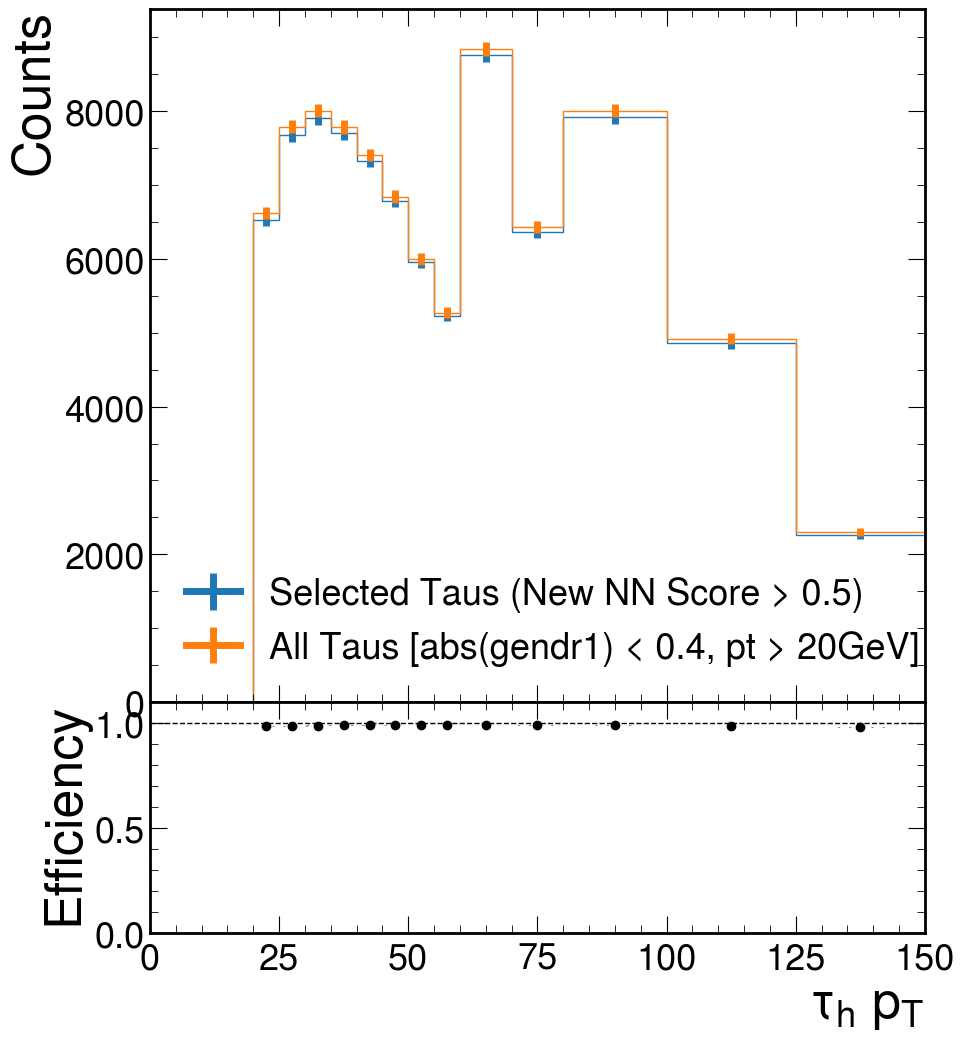

In [15]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

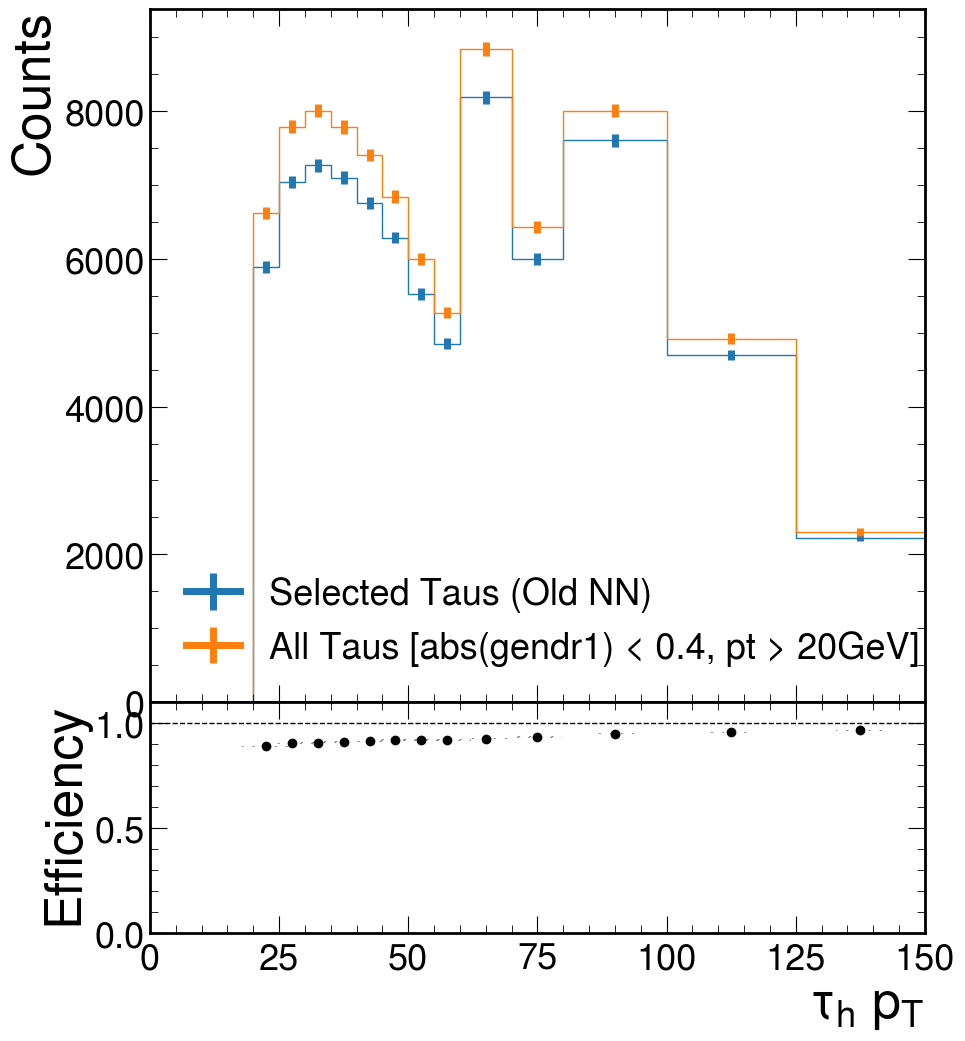

In [16]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

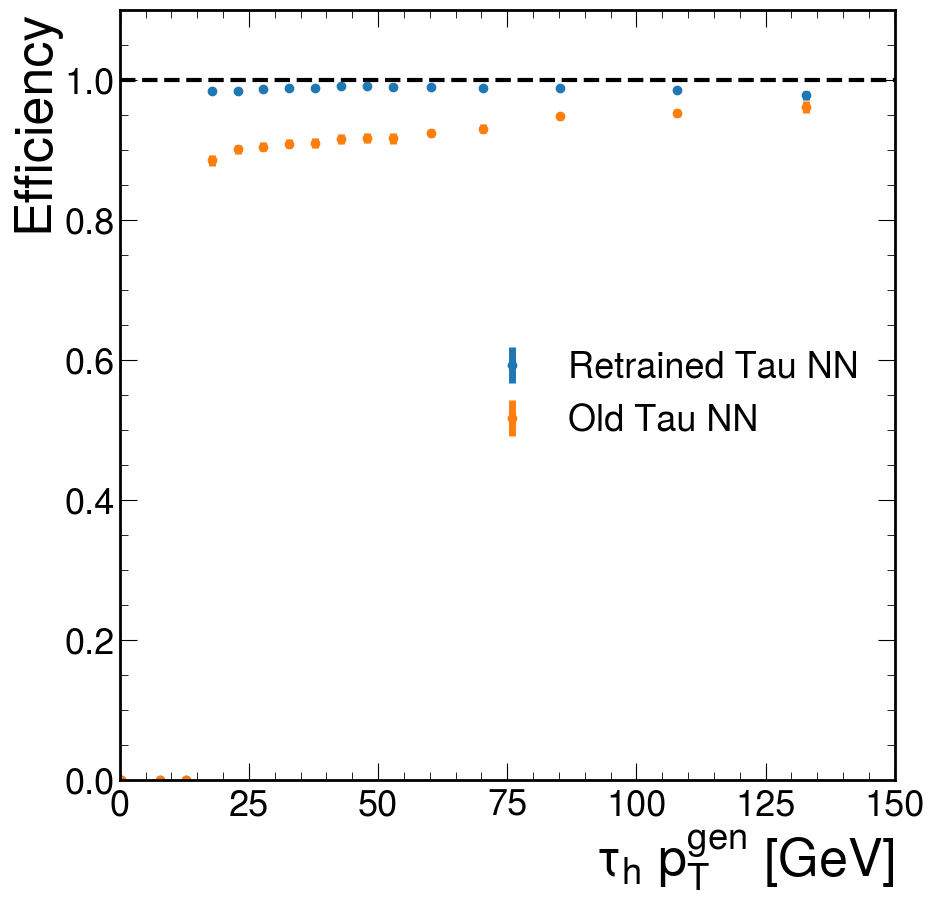

In [17]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

# Fit a function on this